# Data from the web

In [8]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import seaborn
%matplotlib inline

import json
from io import StringIO

import time

# GETTING THE DATA


When we do a little retro engenering on the web sites of www.topuniversities.com and www.timeshighereducation.com, we see that both load a json file with all the data we want. In this homework we will load the json and do a Data analyse.



# QS World University Ranking :  www.topuniversities.com

Here if we look at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt
, we have alt the data in json format.

Firstly, we load the json :

In [9]:
url = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
r =  requests.get(url)
print(r.status_code)

200


Now we interpret the json and put it in a DataFrame

In [10]:
json = json.load(StringIO(r.text))
dataQS = pd.DataFrame(json['data'])

We drop the data which is irrelevant for us.

In [11]:
dataQS.drop("logo",axis=1,inplace=True)
dataQS.drop("guide",axis=1,inplace=True)
dataQS.drop("stars",axis=1,inplace=True)
dataQS.drop("core_id",axis=1,inplace=True)
dataQS.head()

,cc,country,nid,rank_display,region,score,title,url
0,US,United States,294850,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge


Now that we have the information about each university as well as the URL of their web page, we can retrieve the number of student in each university.

We only keep the top-200 universities. Besides, running the script would otherwise take too much time (!)

In [23]:
#we do not use the ranks since some universities have equal rank
dataQS.score = pd.to_numeric(dataQS.score)
dataQS = dataQS.nlargest(200, 'score')

#### Script

In [20]:
#use async for more efficiency
import asyncio

def getnumber(soup,mainclass):
    """ Get the number in div class mainclass in the dom of html page"""
    mainclass_div = soup.findAll('div',{"class":mainclass})
    # if mainclass not found , number ==0
    if(len(mainclass_div)==0):
        return 0
    else :
        return int(mainclass_div[0].findAll("div",{"class":"number"})[0].text.replace(",",""))

    
def setnumber(index,url):
    url_univ = 'https://www.topuniversities.com/'+url
    print(index,url)
    
    # get the web page of the university
    r =  requests.get(url_univ)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # we get number of students, teachers and international staff and students
    return [ (index,"number of students", getnumber(soup,"students-main")),
    (index,"number of international students", getnumber(soup,"int-students-main")),
    (index,"number of faculty members", getnumber(soup,"total faculty")),
    (index,"number of international faculty members",getnumber(soup,"inter faculty"))]

In [28]:
async def main():
    loop = asyncio.get_event_loop()
    futures = [
        loop.run_in_executor(
            None, 
            setnumber, 
            index,
            url
        )
        for index,url in zip(dataQS.index, dataQS["url"])
    ]
    
    for response in await asyncio.gather(*futures):
        for tuble in response : 
            dataQS.set_value(*tuble)

In [29]:
dataQS["number of students"] = 0
dataQS["number of international students"]= 0
dataQS["number of faculty members"] = 0
dataQS["number of international faculty members"] = 0

#loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for index,url in zip(dataQS.index, dataQS["url"]):
     for tuble in setnumber(index,url) :
            dataQS.set_value(*tuble)

dataQS.head()

0 /universities/massachusetts-institute-technology-mit
1 /universities/stanford-university
2 /universities/harvard-university
3 /universities/california-institute-technology-caltech
4 /universities/university-cambridge
5 /universities/university-oxford
6 /universities/ucl-university-college-london
7 /universities/imperial-college-london
8 /universities/university-chicago
9 /universities/eth-zurich-swiss-federal-institute-technology
10 /universities/nanyang-technological-university-singapore-ntu
11 /universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl
12 /universities/princeton-university
13 /universities/cornell-university
14 /universities/national-university-singapore-nus
15 /universities/yale-university
16 /universities/johns-hopkins-university
17 /universities/columbia-university
18 /universities/university-pennsylvania
19 /universities/australian-national-university
20 /universities/university-michigan
21 /universities/duke-university
22 /universities/university-edi

188 /universities/university-reading
189 /universities/indian-institute-science-iisc-bangalore
190 /universities/university-cape-town
191 /universities/scuola-normale-superiore-di-pisa
192 /universities/scuola-superiore-santanna-pisa-di-studi-universitari-e-di-perfezionamento
193 /universities/keio-university-cems-mim
194 /universities/stockholm-university
195 /universities/universitat-aut%C3%B2noma-de-barcelona
196 /universities/texas-am-university
197 /universities/instituto-tecnol%C3%B3gico-y-de-estudios-superiores-de-monterrey
198 /universities/maastricht-university
199 /universities/universidad-de-chile


,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members
0,US,United States,294850,1,North America,100.0,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067,3717,2982,1679
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university,15878,3611,4285,2042
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university,22429,5266,4350,1311
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255,647,953,350
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,18770,6699,5490,2278


### Ratio of faculty members and international students

In [31]:
dataQS['Students:Staff Ratio'] = dataQS['number of students'] / dataQS['number of faculty members']
dataQS['Students international:Students Ratio'] = dataQS['number of international students'] / dataQS['number of students'] 

The *Students:Staff ratio* is sorted in increasing order: a high number of staff per student is perceived as providing higher quality education.

In [32]:
dataQS.sort_values('Students:Staff Ratio', ascending=True).head(5)

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio,Students international:Students Ratio
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255,647,953,350,2.366212,0.286918
15,US,United States,297177,16,North America,90.4,Yale University,/universities/yale-university,12402,2469,4940,1708,2.510526,0.199081
5,GB,United Kingdom,294654,6,Europe,95.3,University of Oxford,/universities/university-oxford,19720,7353,6750,2964,2.921481,0.372870
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,18770,6699,5490,2278,3.418944,0.356899
16,US,United States,294184,17,North America,89.8,Johns Hopkins University,/universities/johns-hopkins-university,16146,4105,4462,1061,3.618557,0.254243


Inversely, the *Students international:Students Ratio* is sorted in decreasing order: a high proportion of international students is perceived as providing a higher interculturality in a university.

In [33]:
dataQS.sort_values('Students international:Students Ratio', ascending=False).head(5)

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio,Students international:Students Ratio
34,GB,United Kingdom,294016,35,Europe,81.8,London School of Economics and Political Scien...,/universities/london-school-economics-politica...,9760,6748,1088,687,8.970588,0.691393
11,CH,Switzerland,294481,12,Europe,91.2,Ecole Polytechnique Fédérale de Lausanne (EPFL),/universities/ecole-polytechnique-f%C3%A9d%C3%...,10343,5896,1695,1300,6.102065,0.570047
7,GB,United Kingdom,294030,8,Europe,93.7,Imperial College London,/universities/imperial-college-london,16090,8746,3930,2071,4.094148,0.543567
198,NL,Netherlands,293985,200,Europe,47.9,Maastricht University,/universities/maastricht-university,16385,8234,1277,502,12.830854,0.502533
47,US,United States,294555,=47,North America,78.6,Carnegie Mellon University,/universities/carnegie-mellon-university,13356,6385,1342,425,9.952310,0.478062


#### *Students:Staff Ratio* by country

In [58]:
dataQS.groupby("country").mean().sort_values('Students:Staff Ratio', ascending=True)['Students:Staff Ratio'].head(5)

country
Russia          4.506335
Saudi Arabia    5.687382
Singapore       6.171431
Malaysia        6.498004
Japan           6.566145
Name: Students:Staff Ratio, dtype: float64

In [71]:
dataQS.groupby("country").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

cc        country     nid rank_display         region  \
country                                                                    
Argentina     74   AR      Argentina  294578           75  Latin America   
Australia     19   AU      Australia  294616           20        Oceania   
              46   AU      Australia  297460          =47        Oceania   
              110  AU      Australia  294644         =109        Oceania   
              41   AU      Australia  294861          =41        Oceania   
              92   AU      Australia  297188          =93        Oceania   
              44   AU      Australia  294788           45        Oceania   
              49   AU      Australia  296815           50        Oceania   
              59   AU      Australia  294848           60        Oceania   
              175  AU      Australia  297273          176        Oceania   
Austria       153  AT        Austria  297209          154         Europe   
              184  AT        Austria  297208         =182         Europe   
Belgium       181  BE        Belgium  294582         =182         Europe   
              125  BE        Belgium  294329         =125         Europe   
              71   BE        Belgium  294551          =71         Europe   
              152  BE        Belgium  294550          153         Europe   
Brazil        120  BR         Brazil  297422          121  Latin America   
              182  BR         Brazil  294560         =182  Latin America   
Canada        139  CA         Canada  294863          140  North America   
              30   CA         Canada  297242           31  North America   
              31   CA         Canada  294864           32  North America   
              90   CA         Canada  294639          =90  North America   
              50   CA         Canada  294586           51  North America   
              129  CA         Canada  294843          130  North America   
              151  CA         Canada  297191          152  North America   
Chile         137  CL          Chile  294549         =137  Latin America   
              199  CL          Chile  294535          201  Latin America   
China         24   CN          China  297235           25           Asia   
              39   CN          China  294367           40           Asia   
              96   CN          China  294534           97           Asia   
...                ..            ...     ...          ...            ...   
United States 168  US  United States  294505          169  North America   
              54   US  United States  297183           55  North America   
              88   US  United States  297437           89  North America   
              52   US  United States  294584           53  North America   
              85   US  United States  294741           86  North America   
              12   US  United States  297490           13  North America   
              13   US  United States  294514           14  North America   
              80   US  United States  294593           81  North America   
              183  US  United States  294520         =182  North America   
              177  US  United States  294394          178  North America   
              174  US  United States  297205         =173  North America   
              38   US  United States  294567          =38  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              47   US  United States  294555          =47  North America   
              26   US  United States  294572           27  North America   
              104  US  United States  297485          105  North America   
              162  US  United States  294852          163  North America   
              131  US  United States  297286          132  North America   
              93   US  United States  297570          =93  North Am

#### *Students:Staff Ratio* by region

In [43]:
dataQS.groupby("region").mean().sort_values('Students:Staff Ratio', ascending=True)['Students:Staff Ratio'].head(5)

region
Asia              7.977623
North America     9.214235
Europe            9.874120
Latin America    11.235437
Africa           11.305828
Name: Students:Staff Ratio, dtype: float64

In [72]:
dataQS.groupby("region").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

cc        country     nid rank_display         region  \
region                                                                     
Africa        190  ZA   South Africa  294558          191         Africa   
Asia          70   KR    South Korea  297501          =71           Asia   
              75   JP          Japan  297250          =76           Asia   
              35   JP          Japan  294111          =36           Asia   
              172  SA   Saudi Arabia  297053         =173           Asia   
              10   SG      Singapore  294821           11           Asia   
              115  JP          Japan  294832         =116           Asia   
              27   JP          Japan  297246          =28           Asia   
              55   JP          Japan  297248           56           Asia   
              14   SG      Singapore  294798           15           Asia   
              113  MY       Malaysia  294877         =114           Asia   
              127  JP          Japan  294103          128           Asia   
              24   CN          China  297235           25           Asia   
              25   HK      Hong Kong  294256           26           Asia   
              107  KR    South Korea  297467          108           Asia   
              122  JP          Japan  294258         =122           Asia   
              48   HK      Hong Kong  294527           49           Asia   
              89   KR    South Korea  294121          =90           Asia   
              36   KR    South Korea  297403          =36           Asia   
              105  KR    South Korea  297129          106           Asia   
              39   CN          China  294367           40           Asia   
              144  IL         Israel  294267          145           Asia   
              154  KR    South Korea  294273          155           Asia   
              40   KR    South Korea  294124          =41           Asia   
              96   CN          China  294534           97           Asia   
              62   JP          Japan  297628           63           Asia   
              37   CN          China  294606          =38           Asia   
              45   HK      Hong Kong  294277           46           Asia   
              95   HK      Hong Kong  294257          =95           Asia   
              193  JP          Japan  294156         =192           Asia   
...                ..            ...     ...          ...            ...   
North America 47   US  United States  294555          =47  North America   
              50   CA         Canada  294586           51  North America   
              26   US  United States  294572           27  North America   
              104  US  United States  297485          105  North America   
              162  US  United States  294852          163  North America   
              131  US  United States  297286          132  North America   
              93   US  United States  297570          =93  North America   
              129  CA         Canada  294843          130  North America   
              32   US  United States  294569           33  North America   
              149  US  United States  294858         =149  North America   
              133  US  United States  294565          134  North America   
              68   US  United States  295060           69  North America   
              164  US  United States  294570         =164  North America   
              66   US  United States  297257           67  North America   
              196  US  United States  297256         =195  North America   
              69   US  United States  294349           70  North America   
              151  CA         Canada  297191          152  North America   
              60   US  United States  297194           61  North America   
              51   US  United States  294786           52  North America   
Oceania       19   AU      Australia  294616           20        Oc

#### *Students international:Students Ratio* by country

In [44]:
dataQS.groupby("country").mean().sort_values('Students international:Students Ratio', ascending=False)['Students international:Students Ratio'].head(5)

country
United Kingdom    0.351308
Australia         0.346878
Switzerland       0.313816
Hong Kong         0.312148
Austria           0.306095
Name: Students international:Students Ratio, dtype: float64

In [73]:
dataQS.groupby("country").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

cc        country     nid rank_display         region  \
country                                                                    
Argentina     74   AR      Argentina  294578           75  Latin America   
Australia     41   AU      Australia  294861          =41        Oceania   
              19   AU      Australia  294616           20        Oceania   
              110  AU      Australia  294644         =109        Oceania   
              49   AU      Australia  296815           50        Oceania   
              44   AU      Australia  294788           45        Oceania   
              59   AU      Australia  294848           60        Oceania   
              175  AU      Australia  297273          176        Oceania   
              46   AU      Australia  297460          =47        Oceania   
              92   AU      Australia  297188          =93        Oceania   
Austria       153  AT        Austria  297209          154         Europe   
              184  AT        Austria  297208         =182         Europe   
Belgium       181  BE        Belgium  294582         =182         Europe   
              152  BE        Belgium  294550          153         Europe   
              71   BE        Belgium  294551          =71         Europe   
              125  BE        Belgium  294329         =125         Europe   
Brazil        182  BR         Brazil  294560         =182  Latin America   
              120  BR         Brazil  297422          121  Latin America   
Canada        31   CA         Canada  294864           32  North America   
              30   CA         Canada  297242           31  North America   
              90   CA         Canada  294639          =90  North America   
              151  CA         Canada  297191          152  North America   
              129  CA         Canada  294843          130  North America   
              50   CA         Canada  294586           51  North America   
              139  CA         Canada  294863          140  North America   
Chile         199  CL          Chile  294535          201  Latin America   
              137  CL          Chile  294549         =137  Latin America   
China         37   CN          China  294606          =38           Asia   
              39   CN          China  294367           40           Asia   
              86   CN          China  297123           87           Asia   
...                ..            ...     ...          ...            ...   
United States 12   US  United States  297490           13  North America   
              38   US  United States  294567          =38  North America   
              18   US  United States  297569           19  North America   
              99   US  United States  297193          100  North America   
              15   US  United States  297177           16  North America   
              52   US  United States  294584           53  North America   
              21   US  United States  294490          =21  North America   
              28   US  United States  294767          =28  North America   
              20   US  United States  294857          =21  North America   
              32   US  United States  294569           33  North America   
              147  US  United States  294471         =147  North America   
              26   US  United States  294572           27  North America   
              149  US  United States  294858         =149  North America   
              85   US  United States  294741           86  North America   
              93   US  United States  297570          =93  North America   
              168  US  United States  294505          169  North America   
              60   US  United States  297194           61  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              54   US  United States  297183           55  North Am

#### *Students international:Students Ratio* by region

In [45]:
dataQS.groupby("region").mean().sort_values('Students international:Students Ratio', ascending=False)['Students international:Students Ratio'].head(5)

region
Oceania          0.329077
Europe           0.245932
North America    0.202437
Africa           0.169703
Asia             0.132394
Name: Students international:Students Ratio, dtype: float64

In [74]:
dataQS.groupby("region").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

cc        country     nid rank_display         region  \
region                                                                     
Africa        190  ZA   South Africa  294558          191         Africa   
Asia          25   HK      Hong Kong  294256           26           Asia   
              48   HK      Hong Kong  294527           49           Asia   
              10   SG      Singapore  294821           11           Asia   
              29   HK      Hong Kong  294255           30           Asia   
              14   SG      Singapore  294798           15           Asia   
              45   HK      Hong Kong  294277           46           Asia   
              95   HK      Hong Kong  294257          =95           Asia   
              113  MY       Malaysia  294877         =114           Asia   
              37   CN          China  294606          =38           Asia   
              172  SA   Saudi Arabia  297053         =173           Asia   
              39   CN          China  294367           40           Asia   
              154  KR    South Korea  294273          155           Asia   
              89   KR    South Korea  294121          =90           Asia   
              105  KR    South Korea  297129          106           Asia   
              107  KR    South Korea  297467          108           Asia   
              86   CN          China  297123           87           Asia   
              24   CN          China  297235           25           Asia   
              55   JP          Japan  297248           56           Asia   
              76   TW         Taiwan  294804          =76           Asia   
              115  JP          Japan  294832         =116           Asia   
              27   JP          Japan  297246          =28           Asia   
              127  JP          Japan  294103          128           Asia   
              62   JP          Japan  297628           63           Asia   
              114  CN          China  294826         =114           Asia   
              75   JP          Japan  297250          =76           Asia   
              35   JP          Japan  294111          =36           Asia   
              161  TW         Taiwan  294800         =161           Asia   
              36   KR    South Korea  297403          =36           Asia   
              122  JP          Japan  294258         =122           Asia   
...                ..            ...     ...          ...            ...   
North America 149  US  United States  294858         =149  North America   
              85   US  United States  294741           86  North America   
              93   US  United States  297570          =93  North America   
              168  US  United States  294505          169  North America   
              139  CA         Canada  294863          140  North America   
              60   US  United States  297194           61  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              54   US  United States  297183           55  North America   
              141  US  United States  297561         =142  North America   
              162  US  United States  294852          163  North America   
              177  US  United States  294394          178  North America   
              66   US  United States  297257           67  North America   
              133  US  United States  294565          134  North America   
              183  US  United States  294520         =182  North America   
              174  US  United States  297205         =173  North America   
              196  US  United States  297256         =195  North America   
              79   US  United States  294836           80  North America   
              51   US  United States  294786           52  North America   
Oceania       41   AU      Australia  294861          =41        Oc

#### Vizualisation

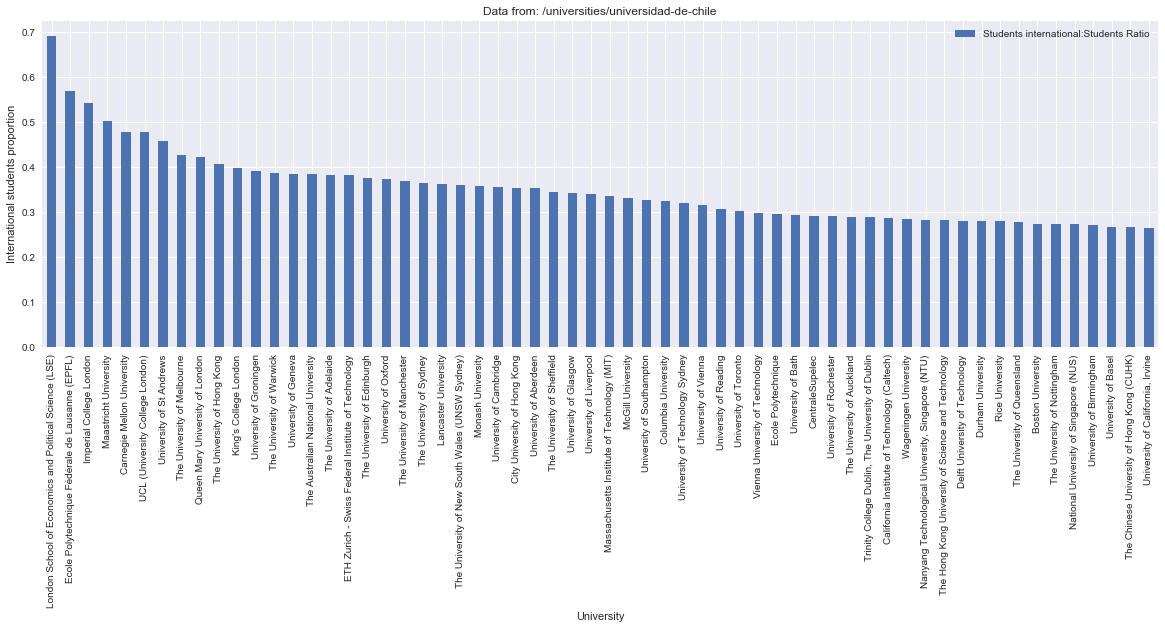

In [49]:
top = 60

ax = dataQS.sort_values('Students international:Students Ratio', ascending=False).head(top).plot(y='Students international:Students Ratio', x='title', kind='bar', grid=True, figsize=(20, 6), title='Data from: ' + url)
ax.set_xlabel('University')
ax.set_ylabel('International students proportion')

## Conclusion


# Times Higher Education University Ranking

Same schema go to : "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

And we have the data at json format

In [54]:
url = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

r =  requests.get(url)
print(r.status_code)
import json
from io import StringIO
json = json.load(StringIO(r.text))
dataTHE = pd.DataFrame(json['data'])

200


In [55]:
dataTHE.drop("record_type",axis=1,inplace=True)
dataTHE.drop("aliases",axis=1,inplace=True)
dataTHE.drop("subjects_offered",axis=1,inplace=True)
dataTHE.drop("scores_teaching_rank",axis=1,inplace=True)
dataTHE.drop("scores_citations",axis=1,inplace=True)
dataTHE.drop("scores_industry_income",axis=1,inplace=True)
dataTHE.drop("scores_citations_rank",axis=1,inplace=True)
dataTHE.drop("scores_industry_income_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook",axis=1,inplace=True)
dataTHE.drop("scores_research",axis=1,inplace=True)
dataTHE.drop("scores_teaching",axis=1,inplace=True)
dataTHE.drop("scores_research_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook_rank",axis=1,inplace=True)

dataTHE.head()

,location,member_level,name,nid,rank,rank_order,scores_international_outlook_rank,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url
0,United Kingdom,0,University of Oxford,468,1,10,24,94.3,10,46 : 54,"20,409",38%,11.2,/world-university-rankings/university-oxford
1,United Kingdom,0,University of Cambridge,470,2,20,35,93.2,20,45 : 55,"18,389",35%,10.9,/world-university-rankings/university-cambridge
2,United States,0,California Institute of Technology,128779,=3,30,322,93.0,30,31 : 69,"2,209",27%,6.5,/world-university-rankings/california-institut...
3,United States,11,Stanford University,467,=3,40,162,93.0,40,42 : 58,"15,845",22%,7.5,/world-university-rankings/stanford-university
4,United States,0,Massachusetts Institute of Technology,471,5,50,81,92.5,50,37 : 63,"11,177",34%,8.7,/world-university-rankings/massachusetts-insti...


In [56]:
dataTHE.rename(columns={'stats_student_staff_ratio':'Students:Staff Ratio'}, inplace=True)
dataTHE.rename(columns={'stats_pc_intl_students':'Students international:Students Ratio'}, inplace=True)

In [57]:

dataTHE.head()

,location,member_level,name,nid,rank,rank_order,scores_international_outlook_rank,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,Students international:Students Ratio,Students:Staff Ratio,url
0,United Kingdom,0,University of Oxford,468,1,10,24,94.3,10,46 : 54,"20,409",38%,11.2,/world-university-rankings/university-oxford
1,United Kingdom,0,University of Cambridge,470,2,20,35,93.2,20,45 : 55,"18,389",35%,10.9,/world-university-rankings/university-cambridge
2,United States,0,California Institute of Technology,128779,=3,30,322,93.0,30,31 : 69,"2,209",27%,6.5,/world-university-rankings/california-institut...
3,United States,11,Stanford University,467,=3,40,162,93.0,40,42 : 58,"15,845",22%,7.5,/world-university-rankings/stanford-university
4,United States,0,Massachusetts Institute of Technology,471,5,50,81,92.5,50,37 : 63,"11,177",34%,8.7,/world-university-rankings/massachusetts-insti...


### 200 top universities

In [58]:
dataTHE = dataTHE.head(200)
dataTHE['Students international:Students Ratio'] = dataTHE['Students international:Students Ratio'].apply(lambda x: int(x.split('%')[0]) / 100)
dataTHE['Students:Staff Ratio'] = pd.to_numeric(dataTHE['Students:Staff Ratio'])

In [59]:
top_international_students = dataTHE.sort_values('Students international:Students Ratio', ascending=False)
top_international_students.head()

,location,member_level,name,nid,rank,rank_order,scores_international_outlook_rank,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,Students international:Students Ratio,Students:Staff Ratio,url
24,United Kingdom,0,London School of Economics and Political Science,511,=25,250,43,79.4,250,52 : 48,"10,065",0.71,12.2,/world-university-rankings/london-school-econo...
178,Luxembourg,6,University of Luxembourg,131698,=179,1790,1,53.8,1790,50 : 50,"4,969",0.57,14.6,/world-university-rankings/university-luxembourg
37,Switzerland,0,École Polytechnique Fédérale de Lausanne,510,=38,380,5,75.3,380,28 : 72,"9,928",0.55,11.2,/world-university-rankings/ecole-polytechnique...
7,United Kingdom,0,Imperial College London,472,8,80,13,89.2,80,37 : 63,"15,857",0.55,11.4,/world-university-rankings/imperial-college-lo...
102,Netherlands,6,Maastricht University,663,103,1030,12,60.4,1030,58 : 42,"16,727",0.50,18.0,/world-university-rankings/maastricht-university


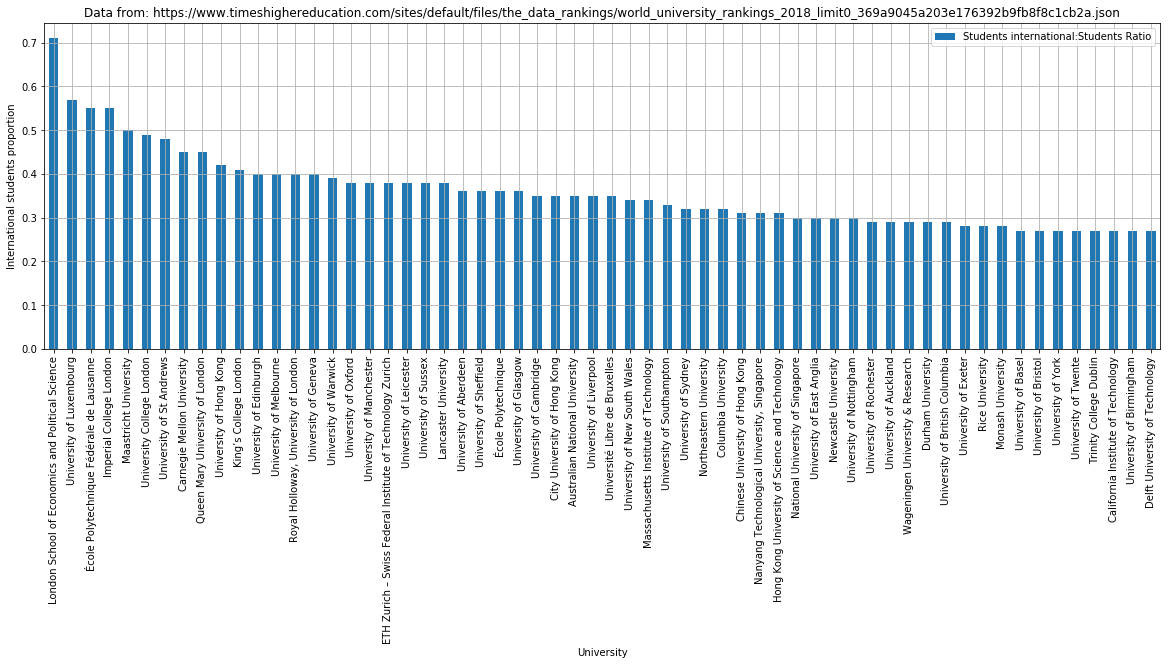

In [60]:
ax = top_international_students.head(60).plot(y='Students international:Students Ratio', x='name', kind='bar', grid=True, figsize=(20, 6), title='Data from: ' + url)
ax.set_xlabel('University')
ax.set_ylabel('International students proportion')

In [63]:
top_student_staff_ratio = dataTHE.sort_values('Students:Staff Ratio', ascending=True)
top_student_staff_ratio.head()

,location,member_level,name,nid,rank,rank_order,scores_international_outlook_rank,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,Students international:Students Ratio,Students:Staff Ratio,url
105,United States,0,Vanderbilt University,534,=105,1060,630,60.0,1060,53 : 47,"12,011",0.13,3.3,/world-university-rankings/vanderbilt-university
109,Denmark,0,University of Copenhagen,599,=109,1100,146,59.4,1100,58 : 42,"30,395",0.14,4.1,/world-university-rankings/university-copenhagen
12,United States,0,Johns Hopkins University,478,13,130,219,86.5,130,52 : 48,"15,498",0.24,4.3,/world-university-rankings/johns-hopkins-unive...
11,United States,0,Yale University,475,12,120,272,87.6,120,49 : 51,"12,155",0.21,4.3,/world-university-rankings/yale-university
153,United States,0,University of Rochester,545,=153,1540,279,55.6,1540,49 : 51,"9,636",0.29,4.3,/world-university-rankings/university-rochester


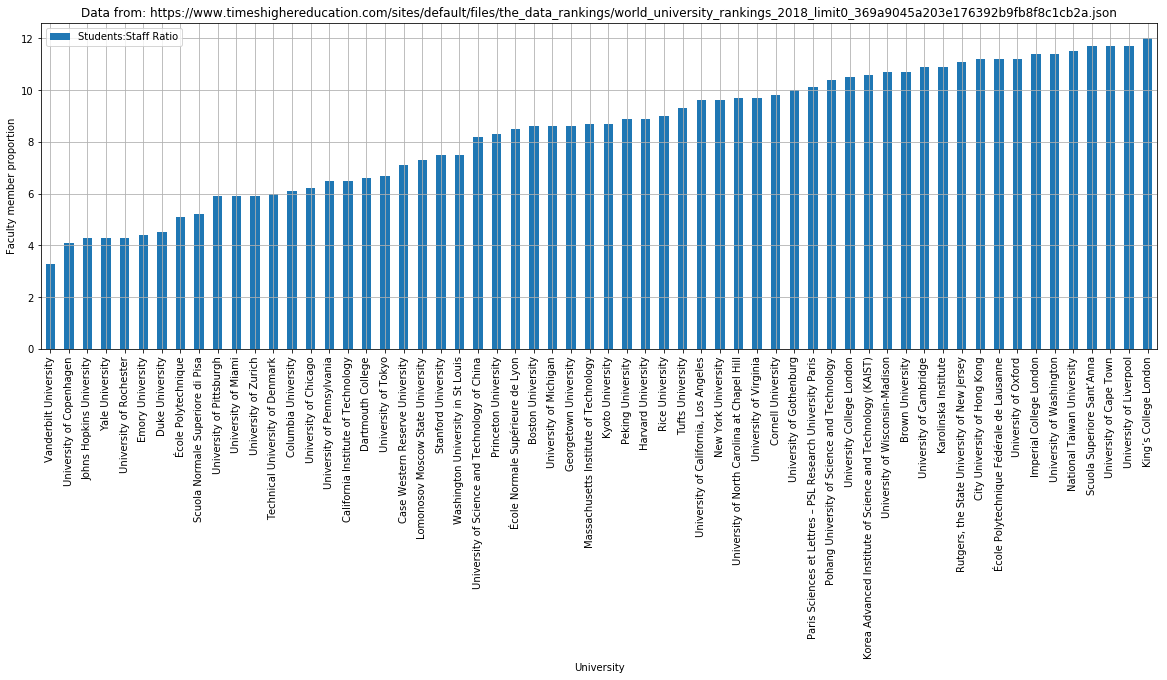

In [64]:
ax = top_student_staff_ratio.head(60).plot(y='Students:Staff Ratio', x='name', kind='bar', grid=True, figsize=(20, 6), title='Data from: ' + url)
ax.set_xlabel('University')
ax.set_ylabel('Faculty member proportion')

Conclusion
======


# MERGING

For mergin we will use a algorithe of fuzzy token, we choose fuzz.token_sort_ratio, it work on sentency like "Université de Machin"

we translate some terms for a better efficienci:

Univedrsité -> University

Universitat -> University

We chossse a thresold of 82 afeter some try.

In [269]:
from fuzzywuzzy import fuzz
def get_closest_match(x, list_strings):
  best_match = x
  highest_jw = 0

  for current_string in list_strings:
    current_score = fuzz.token_sort_ratio(x, current_string)


    if(current_score > highest_jw and  current_score>84): # thresold and country match
      if(dataTHEcpy.loc[dataTHEcpy.name==current_string].location.iloc[0] == dataQScpy.loc[dataQScpy.title==x].country.iloc[0] ) : 
          highest_jw = current_score
          best_match = current_string
        

  if("Oxford" in x):
        print(best_match)
        print(x)
        print(highest_jw)
  return best_match

dataTHEcpy = dataTHE.copy()
dataQScpy = dataQS.copy()

dataTHEcpy.drop("url",axis=1,inplace=True)
dataQScpy.drop("url",axis=1,inplace=True)
dataTHEcpy.drop("scores_international_outlook_rank",axis=1,inplace=True)
dataTHEcpy.drop("scores_overall",axis=1,inplace=True)
dataTHEcpy.drop("stats_female_male_ratio",axis=1,inplace=True)
dataTHEcpy.drop("nid",axis=1,inplace=True)
dataTHEcpy.drop("member_level",axis=1,inplace=True)
dataQScpy.drop("nid",axis=1,inplace=True)


dataQScpy.title = dataQScpy.title.str.replace('Université', 'University')
dataQScpy.title = dataQScpy.title.str.replace('et ', 'and ')
dataQScpy.title = dataQScpy.title.str.replace('Universitat', 'University')
dataQScpy.title = dataQScpy.title.str.replace('Autònoma', 'Autonomous')


dataTHEcpy.rename(columns={'stats_number_students':'number of students'}, inplace=True) 

dataQScpy.title = dataQScpy.title.map(lambda x: get_closest_match(x, dataTHEcpy.name))

print(len(dataQScpy.title.unique()))

merged = dataQScpy.merge(dataTHEcpy,how="outer",left_on="title",right_on="name")

merged[merged.title.isnull() | merged.name.isnull() ]


University of Oxford
University of Oxford
100
200


,cc,country,rank_display,region,score,title,number of students_x,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio_x,Students international:Students Ratio_x,location,name,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y
42,FR,France,43,Europe,79.9,"Ecole normale supérieure, Paris",1907.0,374.0,178.0,75.0,10.713483,0.196120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,AU,Australia,45,Oceania,78.9,The University of New South Wales (UNSW Sydney),39784.0,14292.0,2924.0,1612.0,13.606019,0.359240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,JP,Japan,56,Asia,74.8,Tokyo Institute of Technology,9832.0,1071.0,1563.0,191.0,6.290467,0.108930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,JP,Japan,63,Asia,72.1,Osaka University,22760.0,2106.0,2814.0,296.0,8.088131,0.092531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,DE,Germany,66,Europe,70.8,Ludwig-Maximilians-Universität München,35055.0,5084.0,3274.0,674.0,10.707086,0.145029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,DE,Germany,68,Europe,70.4,Ruprecht-Karls-Universität Heidelberg,28852.0,5298.0,3908.0,756.0,7.382805,0.183627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,AR,Argentina,75,Latin America,69.1,Universidad de Buenos Aires (UBA),122301.0,27109.0,16421.0,3165.0,7.447841,0.221658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,JP,Japan,=76,Asia,69.0,Tohoku University,17827.0,1604.0,3411.0,264.0,5.226327,0.089976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,IE,Ireland,88,Europe,65.7,"Trinity College Dublin, The University of Dublin",14961.0,4311.0,1249.0,544.0,11.978383,0.288149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,KR,South Korea,=90,Asia,65.5,Korea University,25892.0,3638.0,3745.0,339.0,6.913752,0.140507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So we see that 51 university of www.topuniversities.com  dosent have a equivalent in  www.timeshighereducation.com
We can only hopping that University that have the same name have merging , we can't be sure a 100%

In [273]:
print(dataQS[dataQS['title'].str.contains("Montréal")]["title"] )


129    Université de Montréal
Name: title, dtype: object


In [274]:
print(dataTHE[dataTHE['name'].str.contains("mont")]["name"] )

Series([], Name: name, dtype: object)


In [275]:
print(fuzz.token_sort_ratio("Massachusetts Institute of Technology","Massachusetts Institute of Technology (MIT)"))
fuzz.token_sort_ratio("City University of Hong Kong","The University of Hong Kong")

95


84

In [285]:
mergednotnull = merged[~(merged.title.isnull() | merged.name.isnull()) ].copy()

In [286]:
mergednotnull

,cc,country,rank_display,region,score,title,number of students_x,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio_x,Students international:Students Ratio_x,location,name,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,3.711268,0.335863,United States,Massachusetts Institute of Technology,5,50,50,"11,177",0.34,8.7
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,3.705484,0.227422,United States,Stanford University,=3,40,40,"15,845",0.22,7.5
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,5.156092,0.234785,United States,Harvard University,6,60,60,"20,326",0.26,8.9
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,2.366212,0.286918,United States,California Institute of Technology,=3,30,30,"2,209",0.27,6.5
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,3.418944,0.356899,United Kingdom,University of Cambridge,2,20,20,"18,389",0.35,10.9
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,2.921481,0.372870,United Kingdom,University of Oxford,1,10,10,"20,409",0.38,11.2
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,4.898345,0.477928,United Kingdom,University College London,16,160,160,"30,304",0.49,10.5
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,4.094148,0.543567,United Kingdom,Imperial College London,8,80,80,"15,857",0.55,11.4
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,5.535729,0.249244,United States,University of Chicago,9,90,90,"13,525",0.25,6.2
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,7.999596,0.381681,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,=10,100,100,"19,233",0.38,14.6


In [287]:
#Cleaning
mergednotnull.drop("name",axis=1,inplace=True)
mergednotnull.drop("rank",axis=1,inplace=True)
mergednotnull.drop("scores_overall_rank",axis=1,inplace=True)
mergednotnull.drop("location",axis=1,inplace=True)
mergednotnull

,cc,country,rank_display,region,score,title,number of students_x,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio_x,Students international:Students Ratio_x,rank_order,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,3.711268,0.335863,50,"11,177",0.34,8.7
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,3.705484,0.227422,40,"15,845",0.22,7.5
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,5.156092,0.234785,60,"20,326",0.26,8.9
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,2.366212,0.286918,30,"2,209",0.27,6.5
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,3.418944,0.356899,20,"18,389",0.35,10.9
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,2.921481,0.372870,10,"20,409",0.38,11.2
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,4.898345,0.477928,160,"30,304",0.49,10.5
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,4.094148,0.543567,80,"15,857",0.55,11.4
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,5.535729,0.249244,90,"13,525",0.25,6.2
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,7.999596,0.381681,100,"19,233",0.38,14.6


Correlation
======